# (18) fit — iterative pvae

**Motivation**: host = ```chewie```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick

device_idx = 0
device = f'cuda:{device_idx}'

## Fit one model

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'jac|mlp+b')

cfg_vae['n_latents'] = [128]
cfg_vae['init_scale'] = 1e-2
cfg_vae['seq_len'] = 10

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 500
cfg_tr['batch_size'] = 200
cfg_tr['kl_beta'] = 5.0
cfg_tr['kl_balancer'] = None

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'MNIST', 'n_latents': [128], 'prior_clamp': -2, 'enc_type': 'jac', 'dec_type': 'mlp', 'enc_bias': 
False, 'dec_bias': True, 'init_dist': 't', 'init_scale': 0.01, 'seq_len': 10}

Trainer:
{'epochs': 500, 'batch_size': 200, 'warm_restart': 2, 'optimizer_kws': {'weight_decay': 0.0003}, 'grad_clip': 1000,
'kl_const_portion': 0.01, 'lr': 0.002, 'kl_beta': 5.0, 'kl_balancer': None}

### Make model + trainer

In [4]:
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  467.4 K   |
|     ———     |    ———     |
|  layers.L_0 |  467.4 K   |
+-------------+------------+

poisson_uniform_c(-2)_MNIST_t-10_z-[128]_k-32_<jac|mlp+b>
mc_b200-ep500-lr(0.002)_beta(5:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_09_02,14:03)

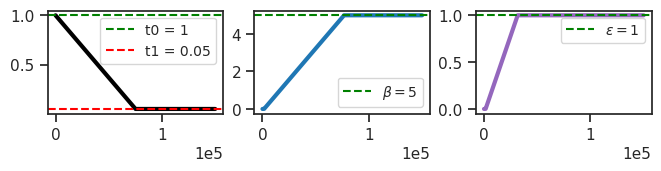

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print(tr.model.input_layer)

PoissonLayer(dim=128, input_dim=28, temp=1, n_exp=263, beta=1, eps=0)

### Fit model

In [7]:
tr.train(fit_name=f"ddu-score_{tr.cfg.name()}")

epoch # 11, avg loss: 4820247371693165614917203525632.000000:   2%| | 11/500 [01


AssertionError: must be positive, got: nan

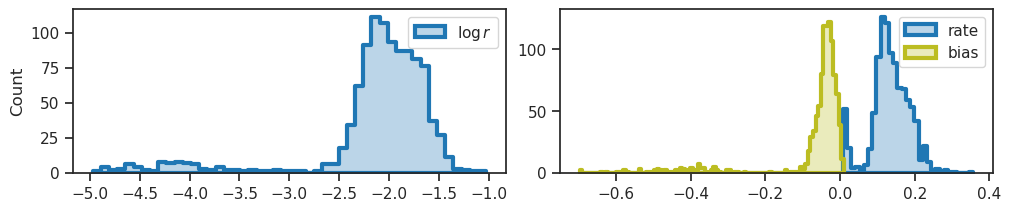

In [8]:
log_rate = tonp(tr.model.input_layer.log_rate).ravel()
bias = tonp(tr.model.input_layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [9]:
results = tr.analysis(3000, verbose=True)

100%|██████████████████████████████| 50/50 [1:32:22<00:00, 110.85s/it]


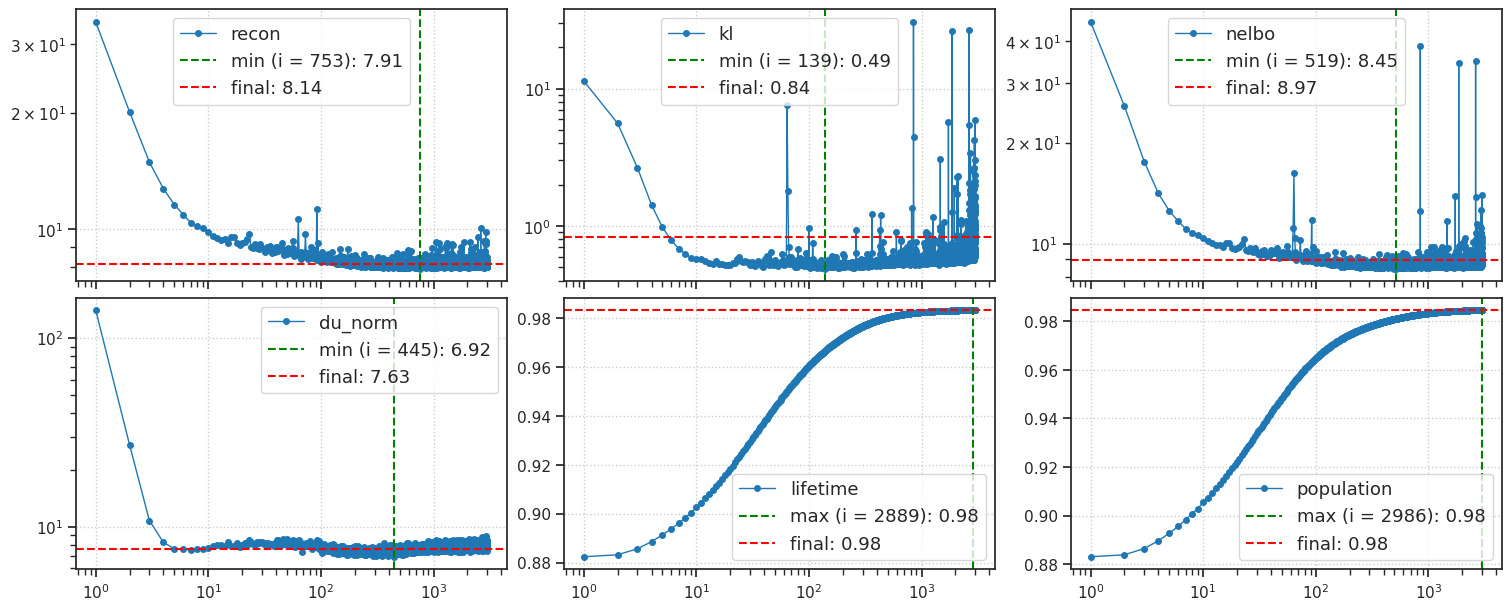

In [10]:
from figures.analysis import plot_convergence
plot_convergence(results)

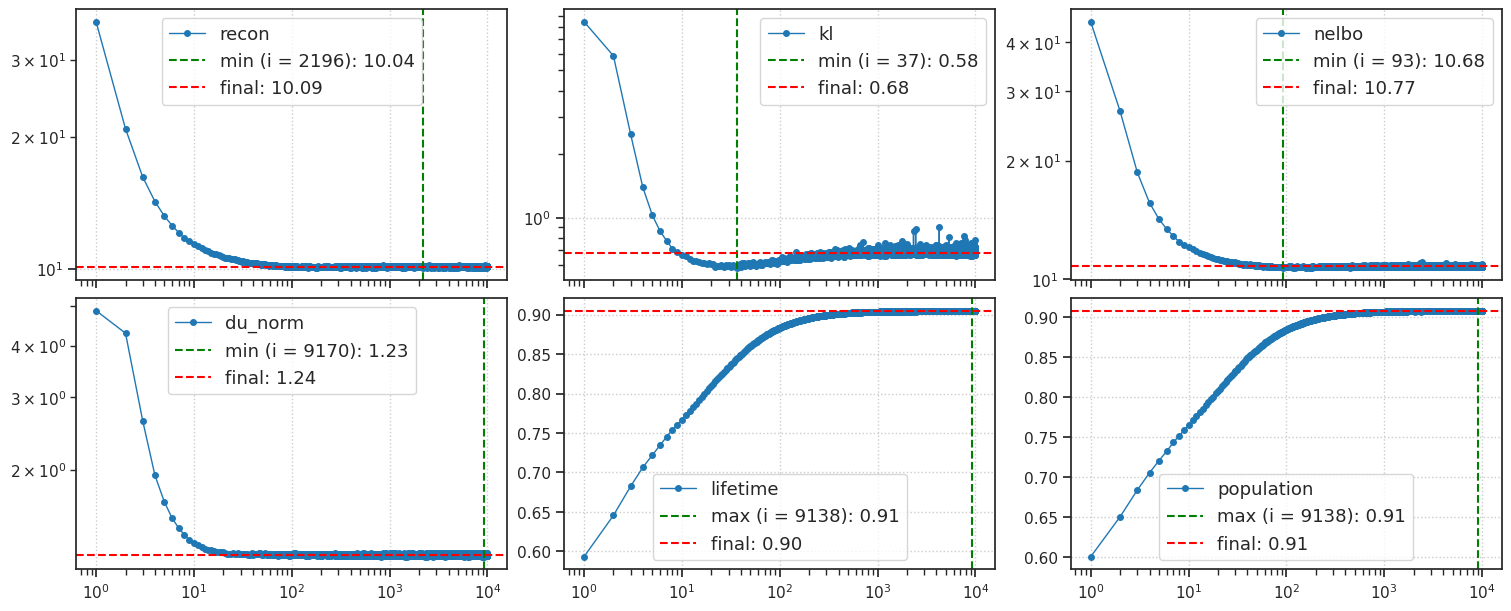

In [14]:
## Was:

# cfg_vae['n_latents'] = 1024
# cfg_vae['init_scale'] = 1e-2
# cfg_vae['seq_len'] = 5

# cfg_tr['lr'] = 2e-3
# cfg_tr['epochs'] = 400
# cfg_tr['batch_size'] = 200
# cfg_tr['kl_beta'] = 3.0

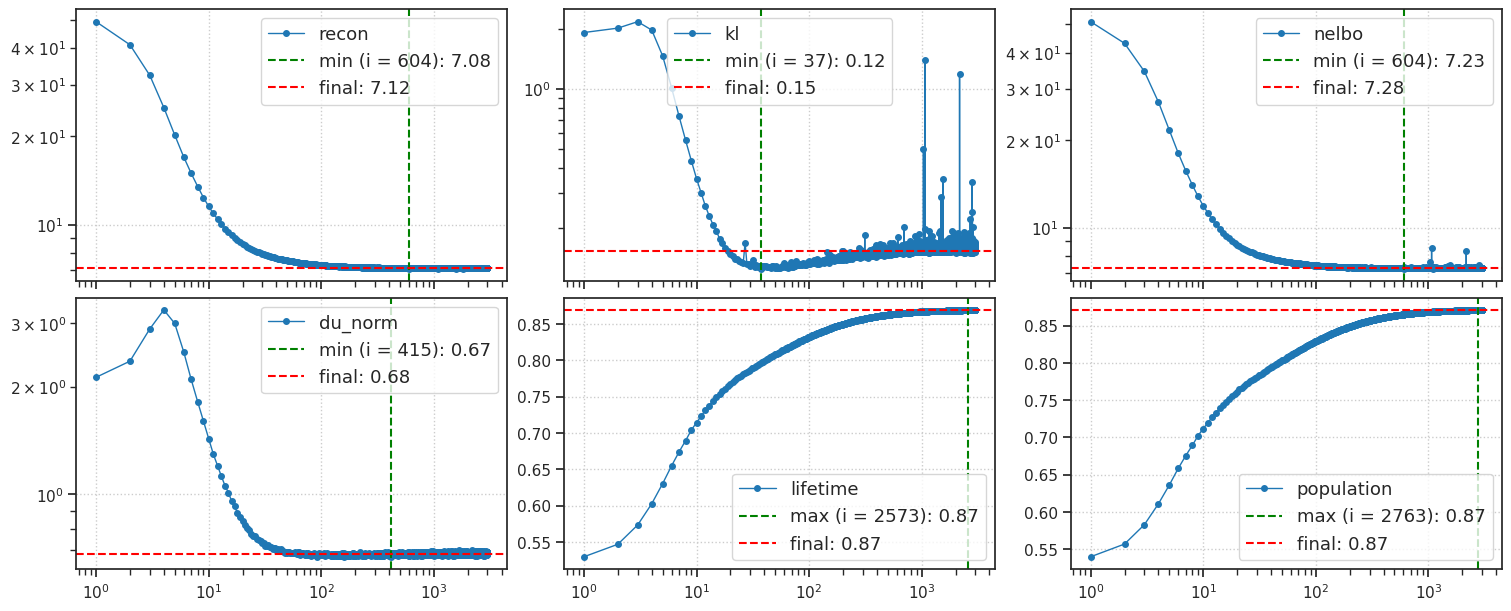

In [10]:
## Was: T = 20, beta = 20.0

## Load model / generate / eval

In [4]:
model_name = 'poisson_uniform_c(-2)_MNIST_t-5_z-[128]_k-32_<jac|mlp+b>'
fit_name = 'mc_b200-ep400-lr(0.002)_beta(3:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_08_31,06:45)'
tr, meta = load_model(model_name, fit_name, device=device)

In [5]:
tr.cfg.kl_balancer

'equal'

In [6]:
results = tr.analysis(10000, verbose=True)

100%|█████████████████████████████████| 50/50 [25:34<00:00, 30.68s/it]


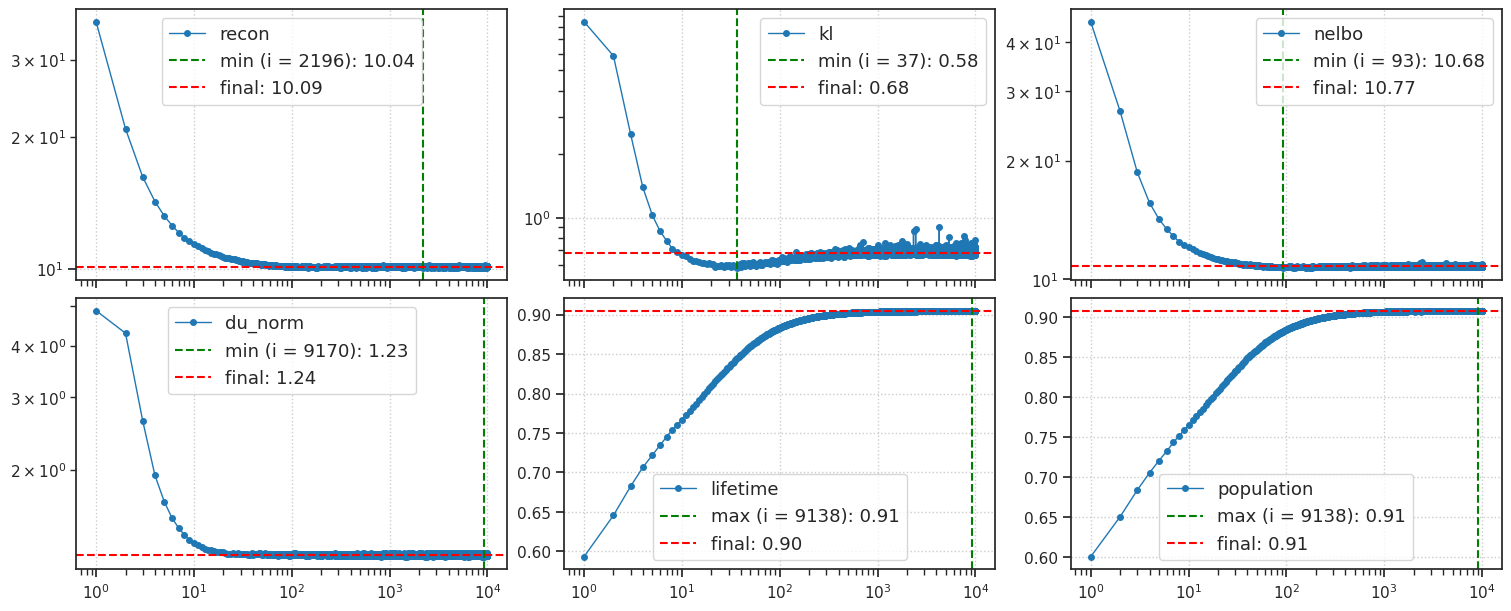

In [7]:
from figures.analysis import plot_convergence
plot_convergence(results)

### generate

In [8]:
self = tr.model.input_layer
self.reset_state(64)

dist, z, pred = self.generate(0.0)

In [9]:
output = tr.model.generate(pred, seq=range(300))
output = output.stack()

list(output)

['recon', 'ff', 'fb', 'spks', 'dist', 'loss_kl', 'loss_recon']

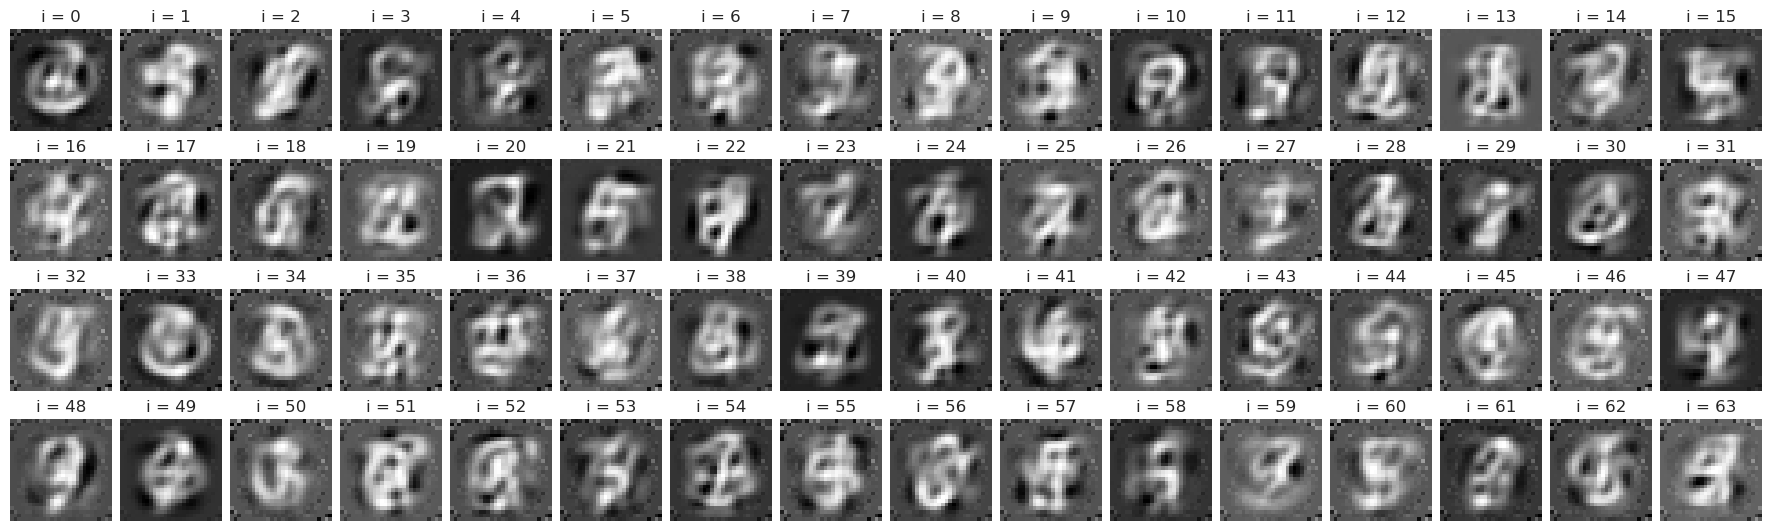

In [10]:
nrows = 4
ncols = int(np.ceil(len(pred) / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')
for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    x2p = tonp(pred[sample_i].reshape(28, 28))
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")
trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [11]:
sample_i = 53

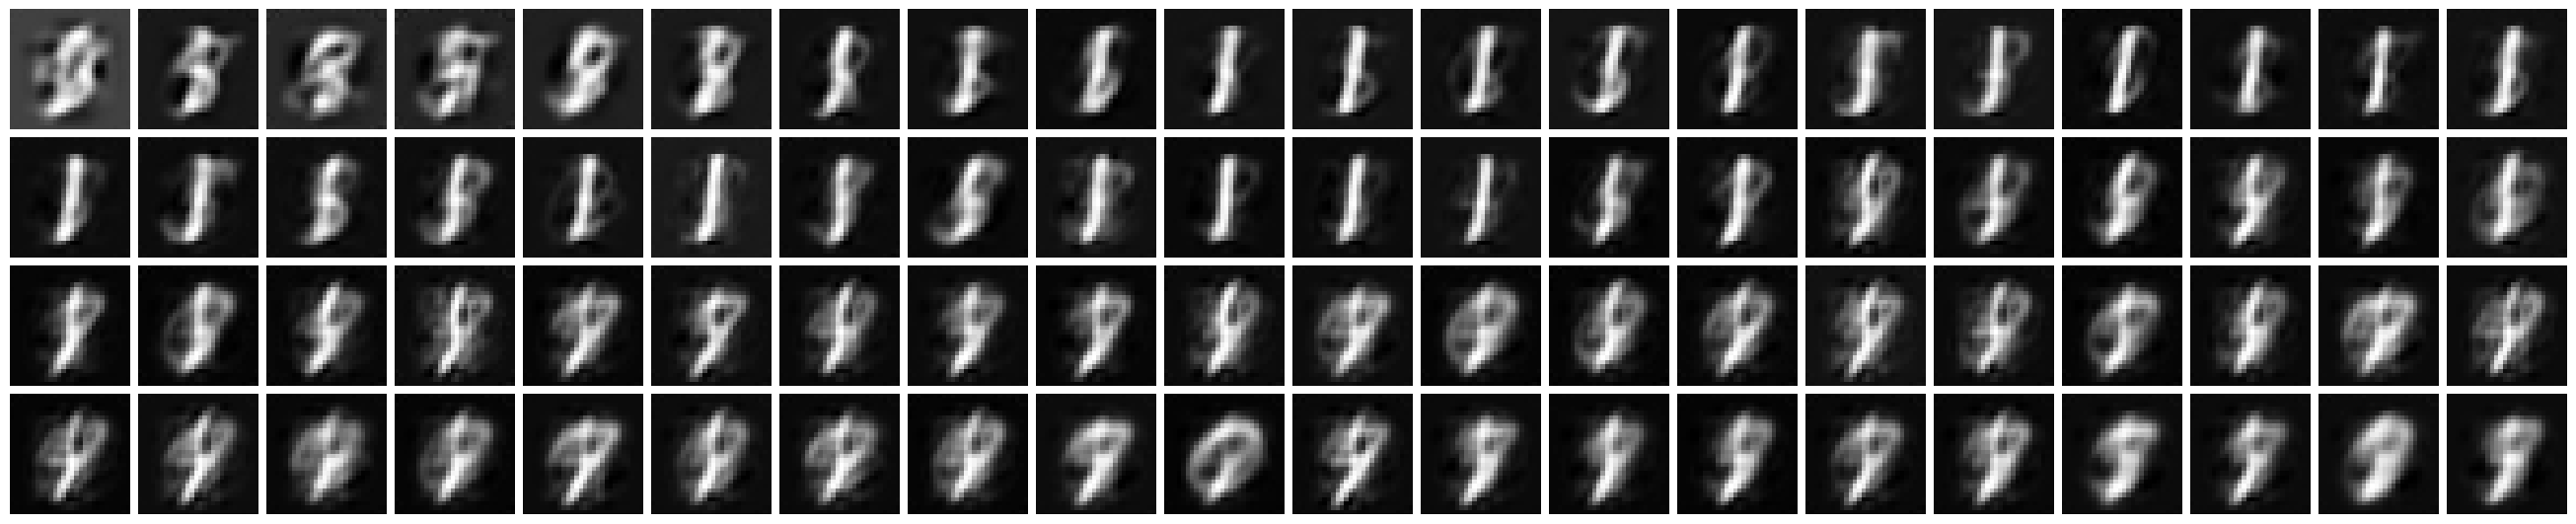

In [12]:
nrows, ncols = 4, 20
fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all')
for idx, ax in enumerate(axes.flat):
    i, j = idx // ncols, idx % ncols
    x2p = tonp(output['recon'][sample_i, idx].reshape(28, 28))
    ax.imshow(x2p, cmap='Greys_r')
remove_ticks(axes)